# stamps - stlr features
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* Feb 25, 2022

## Hypothesis
The goal of this notebook is to compare the results of the model with the model using standard StellarAlgo features with the engineered retention model features.

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [1]:
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from pycaret.classification import *

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
# connect to SQL Server.
SERVER = '34.206.73.189'  
DATABASE = 'datascience' 
USERNAME = 'nrad' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

In [3]:
lkupclientid = 35 # stamps
cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrCFL].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"])

CNXN.commit()
cursor.close()

df.shape

(24759, 54)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24759 entries, 0 to 24758
Data columns (total 54 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   lkupClientId            24759 non-null  int64  
 1   dimCustomerMasterId     24759 non-null  int64  
 2   customerNumber          24759 non-null  object 
 3   year                    24759 non-null  int64  
 4   productGrouping         24759 non-null  object 
 5   totalSpent              24759 non-null  float64
 6   recentDate              24759 non-null  object 
 7   attendancePercent       24759 non-null  float64
 8   renewedBeforeDays       24759 non-null  int64  
 9   isBuyer                 24759 non-null  object 
 10  source_tenure           24759 non-null  int64  
 11  tenure                  24759 non-null  int64  
 12  distToVenue             24759 non-null  float64
 13  totalGames              24759 non-null  int64  
 14  recency                 24759 non-null

### We should specify the features used in our model:

In [5]:
# choose the features for the stellar base retention model
features = [
    "dimCustomerMasterId",
                "totalSpent", 
                "attendancePercent",  
                "renewedBeforeDays",   
                "source_tenure",
                "tenure",
                "totalGames",
                "missed_games_1",
                "missed_games_over_2",
                "click_link",
                "open_email",
                "send_email",
                "openToSendRatio",
                "clickToSendRatio",
                "clickToOpenRatio",
                "credits_after_refund",
                "isNextYear_Buyer",
                "productGrouping",
                "year"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2019]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (16237, 19)
Unseen Data For Predictions: (2865, 19)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [6]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId","productGrouping","year"],
    silent=True,
    verbose=False,
    numeric_features=[
    "totalSpent", 
                "attendancePercent",  
                "renewedBeforeDays",   
                "source_tenure",
                "tenure",
                "totalGames",
                "missed_games_1",
                "missed_games_over_2",
                "click_link",
                "open_email",
                "send_email",
                "openToSendRatio",
                "clickToSendRatio",
                "clickToOpenRatio",
                "credits_after_refund"
    ]
);

In [7]:
model_matrix = compare_models(
    fold=10,
    include=["lr", "xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8394,0.7406,0.9838,0.8464,0.9100,0.2031,0.2720,0.6380
xgboost,Extreme Gradient Boosting,0.8308,0.7476,0.9586,0.8541,0.9034,0.2417,0.2715,0.5920


In [8]:
best_model = create_model(model_matrix)
final_model = finalize_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8429,0.7479,0.9842,0.8492,0.9118,0.2295,0.2995
1,0.8413,0.7671,0.9842,0.8478,0.9109,0.2187,0.2887
2,0.8507,0.7672,0.9886,0.8536,0.9161,0.2702,0.3507
3,0.8333,0.6962,0.9824,0.8419,0.9067,0.1659,0.2290
4,0.8384,0.7207,0.9798,0.8479,0.9091,0.2153,0.2752
5,0.8399,0.7210,0.9860,0.8456,0.9104,0.1959,0.2698
6,0.8348,0.7570,0.9798,0.8448,0.9073,0.1839,0.2424
7,0.8435,0.7527,0.9877,0.8478,0.9124,0.2159,0.2954
8,0.8304,0.7316,0.9763,0.8431,0.9048,0.1664,0.2168
9,0.8384,0.7445,0.9895,0.8423,0.9100,0.1689,0.2518


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

### Let's load in our 2021 season data and get retention scores using the model:

In [9]:
df_inference = df.loc[df["year"] >= 2021]
df_inference = df_inference.fillna(0)
df_inference.shape

(5657, 54)

In [10]:
new_predictions = predict_model(final_model, data=df_inference, raw_score=True)
new_predictions.head()

,lkupClientId,dimCustomerMasterId,customerNumber,year,productGrouping,totalSpent,recentDate,attendancePercent,renewedBeforeDays,isBuyer,...,education,urbanicity,credits_after_refund,is_Lockdown,NumberofGamesPerSeason,CNTPostponedGames,isNextYear_Buyer,Label,Score_0,Score_1
19102,35,326205742,1141317,2021,Full Season,495.74,2021-10-23,0.666667,57,TRUE,...,0,0,0.0,1,7,0,1,1,0.4132,0.5868
19103,35,326206125,129970,2021,Full Season,574.84,2021-10-23,0.750000,31,TRUE,...,0,0,0.0,1,7,0,1,1,0.0019,0.9981
19104,35,326206135,1483552,2021,Full Season,505.40,2021-11-20,0.833333,4,TRUE,...,0,0,0.0,1,7,0,1,0,0.6852,0.3148
19105,35,326206221,1017005,2021,Full Season,956.06,2021-11-20,0.916667,57,TRUE,...,0,0,0.0,1,7,0,1,1,0.4307,0.5693
19106,35,326206408,729539,2021,Full Season,2482.48,2021-11-20,1.125000,57,TRUE,...,0,0,0.0,1,7,0,1,1,0.2776,0.7224


In [11]:
new_predictions["Label"].value_counts()

1    4188
0    1469
Name: Label, dtype: int64

In [12]:
new_predictions["Score_1"].value_counts(bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

(0.6, 0.8]       2444
(0.4, 0.6]       1677
(0.8, 1.0]        861
(0.2, 0.4]        651
(-0.001, 0.2]      24
Name: Score_1, dtype: int64

array([[<AxesSubplot:title={'center':'Score_1'}>]], dtype=object)

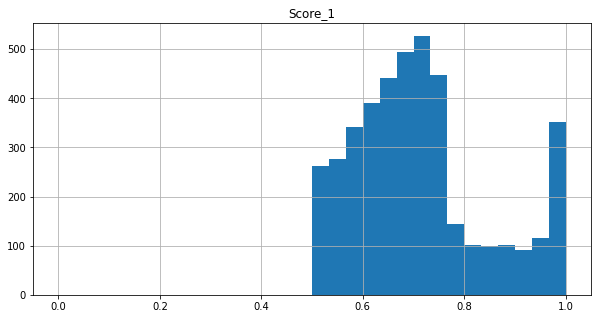

In [13]:
new_predictions[new_predictions["Label"]==1][["Score_1"]].hist(bins=30, figsize=(10,5), range=[0,1])

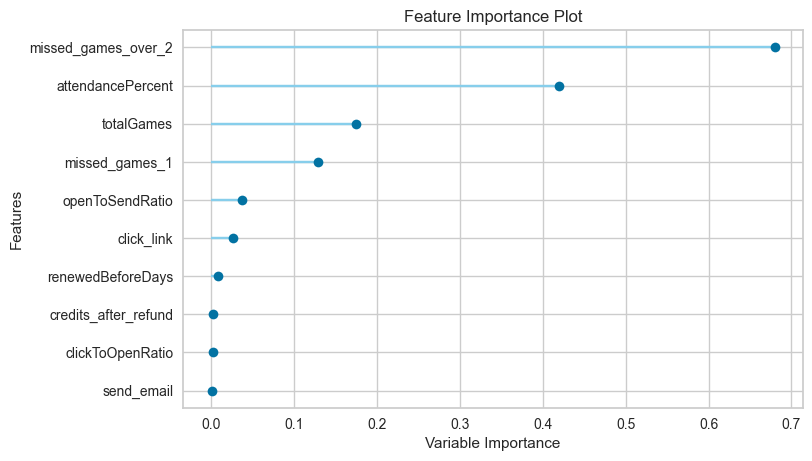

In [14]:
plot_model(best_model, plot='feature')

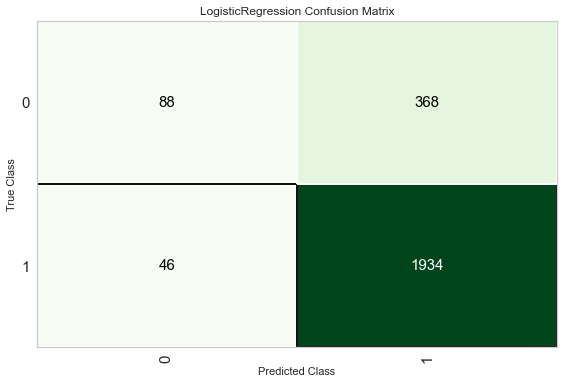

In [15]:
plot_model(best_model, plot='confusion_matrix')

## Observations
Here you can document some ideas on the results from above


## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?